In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
import scipy as sp

from collections import namedtuple
from tqdm import tqdm

import matplotlib.pyplot as plt

from skimage import io
from torchvision import transforms
import torchvision
import skimage
from PIL import Image

import os

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

import lightning.pytorch as pl

In [3]:

# download data
root = "./pets/"
# SimpleOxfordPetDataset.download(root)

KeyboardInterrupt: 

In [5]:

train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

In [6]:

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 3312
Valid size: 368
Test size: 3669


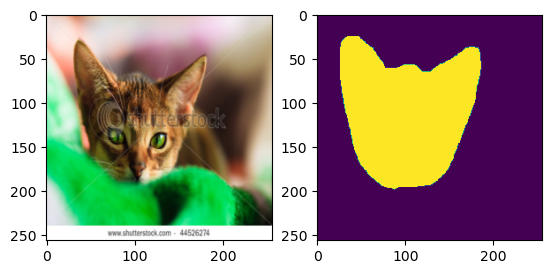

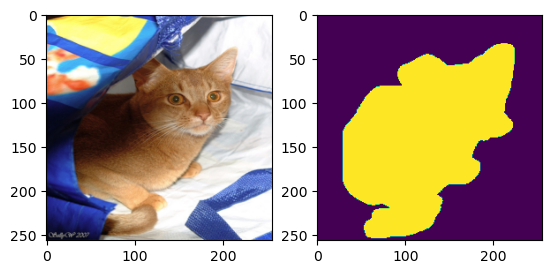

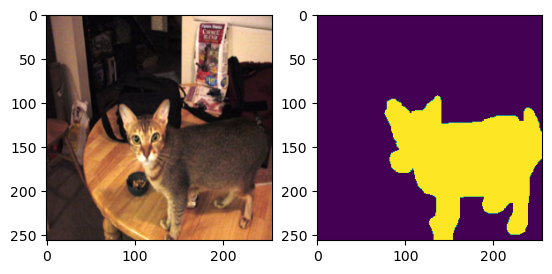

In [7]:

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) 
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())
plt.show()
     

In [17]:
# from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb

class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    # def training_epoch_end(self, outputs):
    #     return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    # def validation_epoch_end(self, outputs):
    #     return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    # def test_epoch_end(self, outputs):
    #     return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
     


In [19]:
model = PetModel("FPN", "resnet18", in_channels=3, out_classes=1)


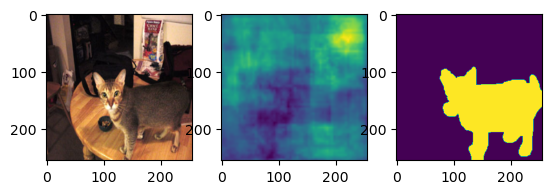

In [20]:
sample1 = transforms.ToTensor()(sample['image'].transpose(1,2,0))
sample1 = sample1.unsqueeze(0)

out1 = model.forward(sample1).detach().numpy()[0][0]

plt.subplot(1,3,1)
plt.imshow(sample['image'].transpose(1,2,0))
plt.subplot(1,3,2)
plt.imshow(out1)
plt.subplot(1,3,3)
plt.imshow(sample['mask'].squeeze())
plt.show()
     

In [21]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=5)
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)
     

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\mkrooted\Uni\8-data-analysis\lab1\lightning_logs

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 13.0 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
13.0 M    Trainable params
0         Non-trainable params
13.0 M    Total params
52.189    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\mkrooted\miniconda3\envs\ds2\lib\site-packages\lightning\pytorch\trainer\call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


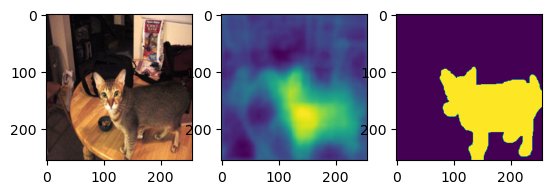

In [25]:
sample1 = transforms.ToTensor()(sample['image'].transpose(1,2,0))
sample1 = sample1.unsqueeze(0)

out1 = model.forward(sample1).detach().numpy()[0][0]

plt.subplot(1,3,1)
plt.imshow(sample['image'].transpose(1,2,0))
plt.subplot(1,3,2)
plt.imshow(out1)
plt.subplot(1,3,3)
plt.imshow(sample['mask'].squeeze())
plt.show()
     

In [26]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

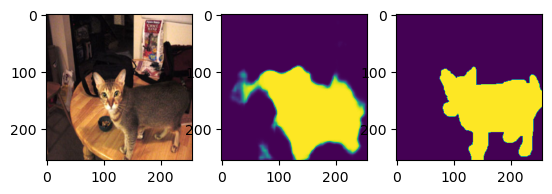

In [27]:
sample1 = transforms.ToTensor()(sample['image'].transpose(1,2,0))
sample1 = sample1.unsqueeze(0)

out1 = model.forward(sample1).detach().numpy()[0][0]

plt.subplot(1,3,1)
plt.imshow(sample['image'].transpose(1,2,0))
plt.subplot(1,3,2)
plt.imshow(sigmoid(out1))
plt.subplot(1,3,3)
plt.imshow(sample['mask'].squeeze())
plt.show()
     

In [28]:
def iou(A,B):
    return np.minimum(A,B).sum() / np.maximum(A,B).sum()

In [29]:
iou(sample['mask'].squeeze(), sigmoid(out1))

0.7230984

In [30]:
torch.save(model, 'image-segmentation.model')